<a href="https://colab.research.google.com/github/hsnam95/my/blob/main/gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic models with Gensim

### Downloading necessary files
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012


In [1]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data

--2023-05-06 06:58:46--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6483086 (6.2M) [text/csv]
Saving to: ‘data/recipes.csv’

recipes.csv         100%[===================>]   6.18M  --.-KB/s    in 0.07s   

2023-05-06 06:58:46 (87.9 MB/s) - ‘data/recipes.csv’ saved [6483086/6483086]

--2023-05-06 06:58:47--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10501219 (10M) [text/csv]
Saving to: ‘data/state-of-the-union

### Data cleaning

In [2]:
# necessary to downgrade pandas under 2.0 for pyLDAvis
!pip install "pandas<2.0.0" 

import pandas as pd
df = pd.read_csv("data/state-of-the-union.csv")
# Clean it up a little bit, removing non-word characters (numbers and ___ etc)
df.content = df.content.str.replace("[^A-Za-z ]", " ")
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-2-b5b1b77ef5e5>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.content = df.content.str.replace("[^A-Za-z ]", " ")


,year,content
0,1790,George Washington January Fellow Citi...
1,1790,State of the Union Address George Washington ...
2,1791,State of the Union Address George Washington ...
3,1792,State of the Union Address George Washington ...
4,1793,State of the Union Address George Washington ...


### Explore data with Wordcloud

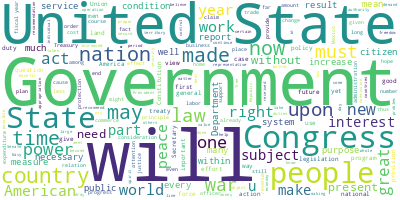

In [3]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df.content.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Prepare data for LDA

gensim.utils.simple_preprocess convert a document into a list of tokens. This lowercases, tokenizes, de-accents (optional)

In [5]:
from gensim.utils import simple_preprocess
df.content = df.content.apply(simple_preprocess)

remove stopwords

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'to']) # add more if want
df.content = df.content.apply(lambda words: [word for word in words if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Using LDA with Gensim

In [16]:
texts = df.content
from gensim import corpora
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 2),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 2),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 2),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 2),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 2),
 (100, 1),

In [24]:
from gensim import models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
corpus_tfidf[0]

[(0, 0.07765267758647285),
 (1, 0.031121807007357907),
 (2, 0.04058541344622125),
 (3, 0.04478789934940984),
 (4, 0.05745947770180516),
 (5, 0.10165499041651212),
 (6, 0.03913227641748322),
 (7, 0.0636122246503216),
 (8, 0.030010652283433862),
 (9, 0.07231474511852554),
 (10, 0.06769081769258485),
 (11, 0.07623909283809405),
 (12, 0.0363970643130554),
 (13, 0.04709728944530448),
 (14, 0.041589194385850896),
 (15, 0.08396611168035908),
 (16, 0.07488095728921708),
 (17, 0.060840504353065844),
 (18, 0.07639265414380708),
 (19, 0.09169313052262411),
 (20, 0.09888327011925634),
 (21, 0.0806657090880804),
 (22, 0.11161685031040011),
 (23, 0.1319707373404376),
 (24, 0.09392797157424708),
 (25, 0.09169313052262411),
 (26, 0.026544960510069993),
 (27, 0.03345716487176589),
 (28, 0.0377376711256989),
 (29, 0.1319707373404376),
 (30, 0.02754874144969964),
 (31, 0.11161685031040011),
 (32, 0.10165499041651212),
 (33, 0.05087864445917784),
 (34, 0.08574229678577741),
 (35, 0.11569544335266337),
 (3

In [25]:
from gensim import models
n_topics = 15
lda_model = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n_topics)

In [ ]:
lda_model.print_topics()

In [30]:
!pip install pyLDAvis
!pip install "pandas<2.0.0" 

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.1
    Uninstalling pandas-2.0.1:
      Successfully uninstalled pandas-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.003568  0.003901       1        1  45.549396
3     -0.007888  0.000370       2        1  14.247892
4      0.019464 -0.002327       3        1  12.332912
1     -0.005728  0.000517       4        1   9.249528
2      0.007358  0.007648       5        1   5.715926
9     -0.004843  0.004369       6        1   3.245826
10    -0.001578 -0.010821       7        1   2.577991
0      0.008104  0.001291       8        1   2.358479
5     -0.006643 -0.000723       9        1   1.301362
14     0.002258  0.004060      10        1   1.271604
8     -0.001620 -0.001987      11        1   0.963331
13     0.005093  0.000899      12        1   0.466869
11    -0.008740 -0.000764      13        1   0.300876
7     -0.008354 -0.001132      14        1   0.253448
6      0.006685 -0.005302      15        1   0.164560, topic_info=           Term        Freq       Total Category  logprob  loglift
9232    tonight  243.000000  243.000000  Default  30.0000  30.0000
8694    program  190.000000  190.000000  Default  29.0000  29.0000
3953     mexico  125.000000  125.000000  Default  28.0000  28.0000
2730  americans  175.000000  175.000000  Default  27.0000  27.0000
8394     budget  165.000000  165.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
6334      child    0.251621   98.150212  Topic15  -7.8786   0.4433
7376       help    0.291093  189.282801  Topic15  -7.7328  -0.0677
8073      today    0.280314  185.203810  Topic15  -7.7706  -0.0837
8722    percent    0.246732  107.557147  Topic15  -7.8982   0.3322
5481     silver    0.246192  107.464628  Topic15  -7.9004   0.3308

[949 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2251      1  0.707269  accommodate
2251      2  0.072540  accommodate
2251      3  0.072540  accommodate
2251      4  0.054405  accommodate
2251      5  0.018135  accommodate
...     ...       ...          ...
8975      6  0.017058          yes
8975      7  0.034117          yes
8975      8  0.034117          yes
8975     10  0.017058          yes
8975     12  0.017058          yes

[6181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 5, 2, 3, 10, 11, 1, 6, 15, 9, 14, 12, 8, 7])